<a href="https://colab.research.google.com/github/swatimishra2019/ViT-for-Cancer-Skin-Classification-TensorFlow/blob/main/train_using_pretrained_model_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive/going_modular')  # Update with your folder path

Mounted at /content/drive


In [5]:
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/tmp/tmp6w8c1gt_', '/content/drive/My Drive/going_modular']


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [3]:

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['daisy','dandelion']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 44.5MB/s]


In [24]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

ModuleNotFoundError: No module named 'torchinfo'

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/prepared PH2 dataset/train'
test_dir = '/content/drive/MyDrive/prepared PH2 dataset/test'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [8]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [9]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [29]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive/going_modular')  # Update with your folder path

Mounted at /content/drive


In [12]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4101 | train_acc: 0.8208 | test_loss: 0.6937 | test_acc: 0.6288
Epoch: 2 | train_loss: 0.2933 | train_acc: 0.8896 | test_loss: 0.6215 | test_acc: 0.7688
Epoch: 3 | train_loss: 0.2635 | train_acc: 0.9167 | test_loss: 0.6195 | test_acc: 0.7688
Epoch: 4 | train_loss: 0.2382 | train_acc: 0.9208 | test_loss: 0.5195 | test_acc: 0.7688
Epoch: 5 | train_loss: 0.2306 | train_acc: 0.9167 | test_loss: 0.5467 | test_acc: 0.7688
Epoch: 6 | train_loss: 0.2295 | train_acc: 0.9271 | test_loss: 0.5260 | test_acc: 0.7688
Epoch: 7 | train_loss: 0.2087 | train_acc: 0.9354 | test_loss: 0.4619 | test_acc: 0.7688
Epoch: 8 | train_loss: 0.1975 | train_acc: 0.9313 | test_loss: 0.5361 | test_acc: 0.7688
Epoch: 9 | train_loss: 0.2537 | train_acc: 0.8958 | test_loss: 0.5010 | test_acc: 0.7688
Epoch: 10 | train_loss: 0.2534 | train_acc: 0.9146 | test_loss: 0.4052 | test_acc: 0.7931


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


In [32]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive/going_modular/helper_functions')  # Update with your folder path

Mounted at /content/drive


In [34]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/My Drive/going_modular', '/tmp/tmpvvj69l8p', '/content/drive/My Drive/going_modular', '/content/drive/My Drive/going_modular', '/content/drive/My Drive/going_modular/helper_functions', '/content/drive/My Drive/going_modular/', '/content/drive/My Drive/going_modular', '/content/drive/My Drive/going_modular/helper_functions']


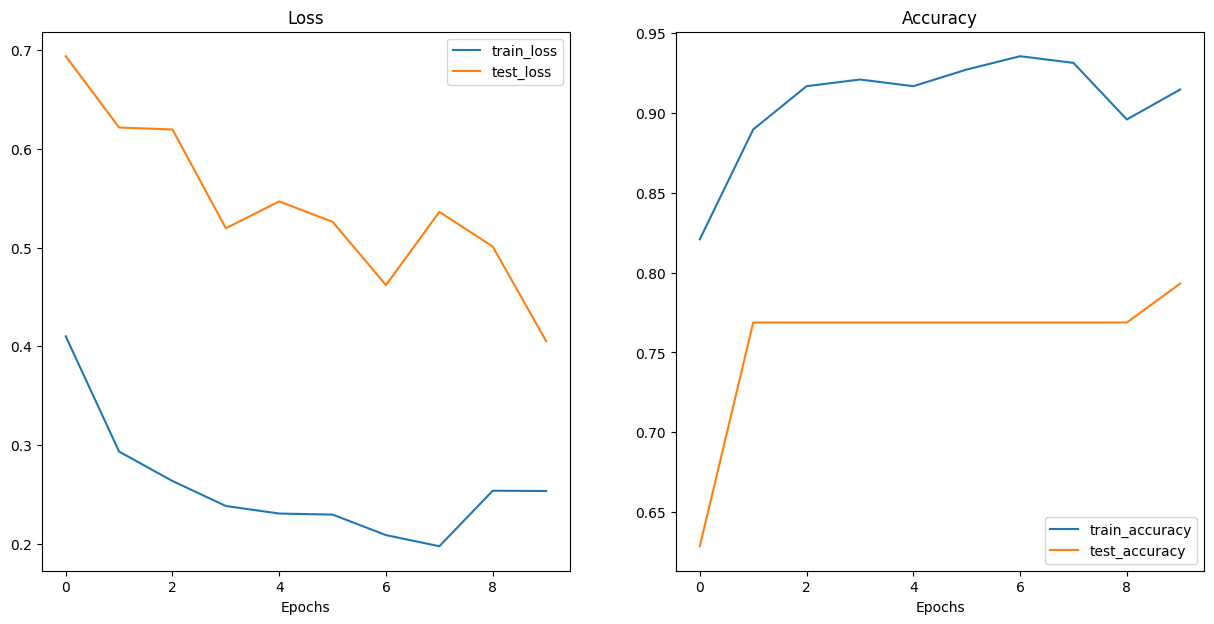

In [35]:
print(sys.path)
# Plot the loss curves
#from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

In [39]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 6.0 MB/s eta 0:00:00


In [42]:
import requests


# Import function to make predictions on images and plot them
from going_modular.predictions import pred_and_plot_image

# Setup custom image path
#custom_image_path = "test_img.jpg"
custom_image_path = "/content/drive/MyDrive/prepared PH2 dataset/test/benign/IMD019/IMD019_Dermoscopic_Image/IMD019.bmp"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

AttributeError: module 'vit_pytorch.vit' has no attribute 'to'